In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import geopy.distance

warnings.simplefilter("ignore")

### Public score 3.27217 
There are many things that can be done to be better, which are followings:
1. Using more data (I only use 1m out of 55m data)
2. Adding more features (like fixed fee to ariports)
3. Removing data in the water
4. Hyperparameters tuning
5. Try different model and blending


### 1. Import Data

In [166]:
# Because of performance of machine, I only use 1,000,000 records to do analysis and modeling
train = pd.read_csv('train.csv', nrows=1000000, parse_dates=['pickup_datetime'])

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
key                  1000000 non-null object
fare_amount          1000000 non-null float64
pickup_datetime      1000000 non-null datetime64[ns]
pickup_longitude     1000000 non-null float64
pickup_latitude      1000000 non-null float64
dropoff_longitude    999990 non-null float64
dropoff_latitude     999990 non-null float64
passenger_count      1000000 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 61.0+ MB


### 2. Data Cleaning and Exploratory Data Analysis

In [4]:
# Drop unnecessary columns 
train = train.drop(columns = 'key')

In [5]:
# 1. missing values
train.isnull().sum()

fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    10
dropoff_latitude     10
passenger_count       0
dtype: int64

In [6]:
train_nm = train.dropna()

In [7]:
train_nm.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

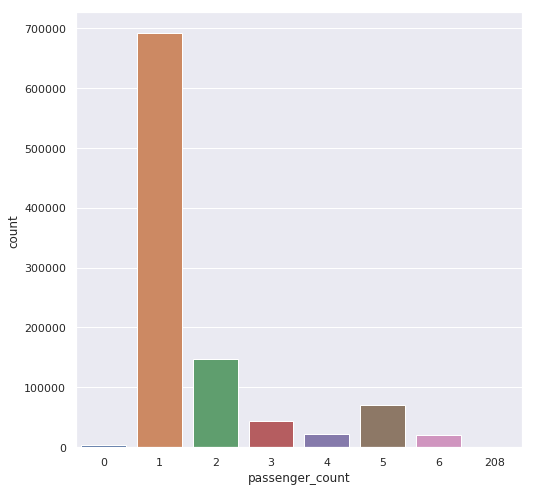

In [8]:
# 2. Abnormal values
# 2.1 abnormal passenger count
sns.set()
plt.figure(figsize = (8,8))
sns.countplot(train_nm.passenger_count)

In [9]:
# There are some outliers, and will infect result
train_tidy = train_nm[train_nm.passenger_count != 0]
train_tidy = train_tidy[train_nm.passenger_count != 208]
train_tidy = train_tidy[train_nm.passenger_count != 129]
train_tidy = train_tidy[train_nm.passenger_count != 51]
train_tidy = train_tidy[train_nm.passenger_count != 9]

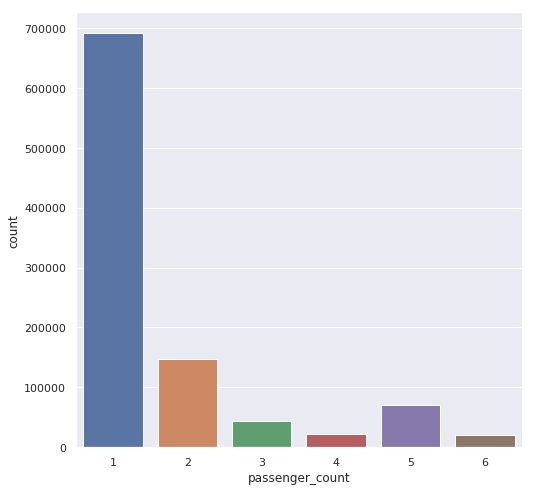

In [10]:
# New plot
plt.figure(figsize = (8,8))
sns.countplot(train_tidy.passenger_count)

In [11]:
# Abnormal fare amount
train_tidy.fare_amount.describe()

count    996434.000000
mean         11.357171
std           9.831673
min         -44.900000
25%           6.000000
50%           8.500000
75%          12.500000
max         500.000000
Name: fare_amount, dtype: float64

In [12]:
# Negative fee is not reasonale
# And starting fare is 2.5$, (2$ before price change)
train_tidy = train_tidy[train_tidy.fare_amount > 2.0]

{'boxes': [<matplotlib.lines.Line2D at 0x7fc37f67f860>],
 'caps': [<matplotlib.lines.Line2D at 0x7fc37ea7e358>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc37f6720b8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fc37ea7ec18>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fc37f67f9e8>,
  <matplotlib.lines.Line2D at 0x7fc37f67feb8>]}

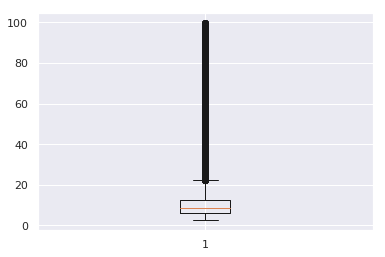

In [13]:
# Look for outliers
# According to disccusion, fare greater than 100 is rare, I regard those as outliers to remove

train_tidy = train_tidy[train_tidy.fare_amount < 100]
plt.boxplot(train_tidy.fare_amount)

In [14]:
# 2.3 Abnormal coordinates
# There codes are borrowed from https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration, and so are codes for mapping
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
            
# load image of NYC map
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

In [15]:
train_ll = train_tidy[select_within_boundingbox(train_tidy, BB)]

Text(0.5,1,'Pickup Location Map')

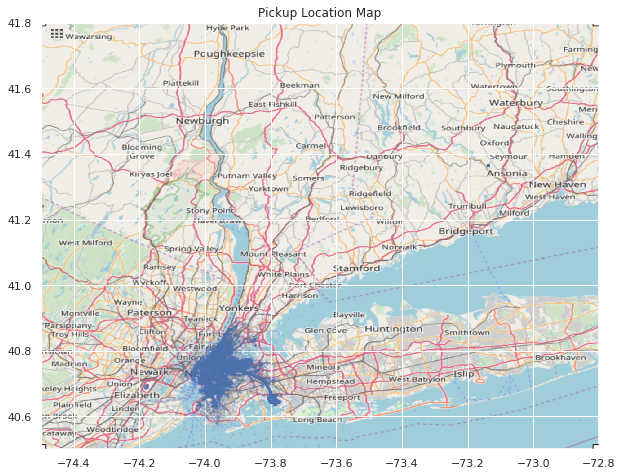

In [16]:
plt.figure(figsize = (10,10))
plt.scatter(x = 'pickup_longitude',y = 'pickup_latitude', data = train_ll, alpha = 0.1, s=2)
plt.imshow(nyc_map, zorder=0, extent=BB)
plt.title('Pickup Location Map')


Text(0.5,1,'Dropoff Location Map')

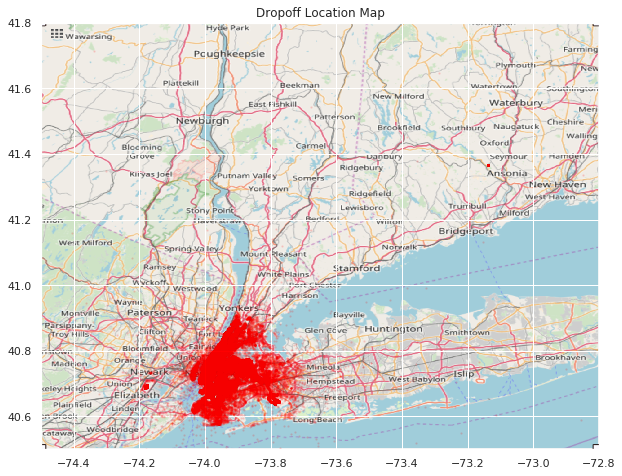

In [17]:
plt.figure(figsize = (10,10))
plt.scatter(x = 'dropoff_longitude',y = 'dropoff_latitude', data = train_ll, alpha = 0.1, s=2, c = 'red')
plt.imshow(nyc_map, zorder=0, extent=BB)
plt.title('Dropoff Location Map')


## 3. Feature Engineering and more EDA

In [18]:
# Get distance

def get_km(lat1,lon1,lat2,lon2):
    coords_1 = (lat1, lon1)
    coords_2 = (lat2, lon2)
    return geopy.distance.geodesic(coords_1, coords_2).km
    

In [19]:
for_dis = train_ll.iloc[:,2:6]

In [20]:
for_dis.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,-73.844311,40.721319,-73.841610,40.712278
1,-74.016048,40.711303,-73.979268,40.782004
2,-73.982738,40.761270,-73.991242,40.750562
3,-73.987130,40.733143,-73.991567,40.758092
4,-73.968095,40.768008,-73.956655,40.783762


In [22]:
distance = []
for inedx,i in for_dis.iterrows():
    lat1 = i['pickup_latitude']
    lon1 = i['pickup_longitude']
    lat2 = i['dropoff_latitude']
    lon2 = i['dropoff_longitude']
    distance.append(get_km(lat1,lon1,lat2,lon2))

In [23]:
train_ll['distance'] = distance

In [24]:
# First only use two features to make baseline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [25]:
def rmse(mse):
    from math import sqrt
    return sqrt(mse)

In [26]:
X = train_ll[['passenger_count','distance']]
y = train_ll['fare_amount']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

In [28]:
lr = LinearRegression()

In [29]:
lr.fit(X_train,y_train)
pred_lr = lr.predict(X_test)

In [30]:
# Test 1
print(rmse(mean_squared_error(y_pred=pred_lr, y_true=y_test)))

5.124869316589456


In [31]:
train_ll.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,1.029601
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,8.443441
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389132
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2.795790
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.998338


In [ ]:
### According to NYC Taxi standard metered fare, we are going to modify data

## 1. 2.5$ initial charge
## 2. Plus fifty cents per one fifth mile when traveling above 12mph or per 60 seconds in slow traffic or when the vehicle is stopped
## 3. Plus fifty cents MTA State Surcharge for all trips that end in New York City or Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties.
## 4. Plus thirty cents Improvement Surcharge.
## 4. Plus fifty cents overnight surcharge 8pm to 6am.
## 5. Plus $1.00 rush hour surcharge from 4pm to 8pm on weekdays, excluding holidays.
## 6. Plus New York State Congestion Surcharge of $2.50 (Yellow Taxi) or $2.75 (Green Taxi and FHV) or 75 cents (any shared ride) for all trips that begin, end or pass through Manhattan south of 96th Street.
## 7. Plus tips and any tolls.
## 8. There is no charge for extra passengers, luggage or bags, or paying by credit card.

## I will add features according to 4,5.

### So now we go explore further!


In [32]:
# Range from 2009 to 2015, from internet, we know there is price change in Sep 4, 2012, which came into force on approximately
# Sep 30, 2012
# So, I will divide data into 2 half
train_ll.loc[train_ll.pickup_datetime < pd.Timestamp('2012/9/30'),'change'] = 0
train_ll.change.fillna(1, inplace = True)

In [33]:
train_dmy = pd.get_dummies(columns=['change'], data = train_ll)

In [34]:
# 2. Explore difference between year, month, week of days, and huors
# And to verify if there is a fare change happening in 2012
train_ll['year'] = train_ll.pickup_datetime.apply(lambda x:x.year)
train_ll['month'] = train_ll.pickup_datetime.apply(lambda x:x.month)
train_ll['day_of_week'] = train_ll['pickup_datetime'].dt.day_name()
train_ll['hour'] = train_ll.pickup_datetime.apply(lambda x:x.hour)

In [35]:
train_ll.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,change,year,month,day_of_week,hour
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,1.029601,0.0,2009,6,Monday,17
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,8.443441,0.0,2010,1,Tuesday,16
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389132,0.0,2011,8,Thursday,0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2.795790,0.0,2012,4,Saturday,4
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.998338,0.0,2010,3,Tuesday,7


In [36]:
def test_linear(x,y):
    X = x
    y = y
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    pred_lr = lr.predict(X_test)
    return rmse(mean_squared_error(y_pred=pred_lr, y_true=y_test))

In [37]:
# Test 2
# Slight improvement
test_linear(train_dmy[['passenger_count','distance','change_0.0','change_1.0']], train_dmy['fare_amount'])

5.065358326984088

In [39]:
# Year
year_day = train_ll.groupby(['year','hour'])[['fare_amount','distance']].mean()

In [40]:
year_day['fare_per_km'] = year_day['fare_amount']/year_day['distance']

In [41]:
year_day = year_day.reset_index()

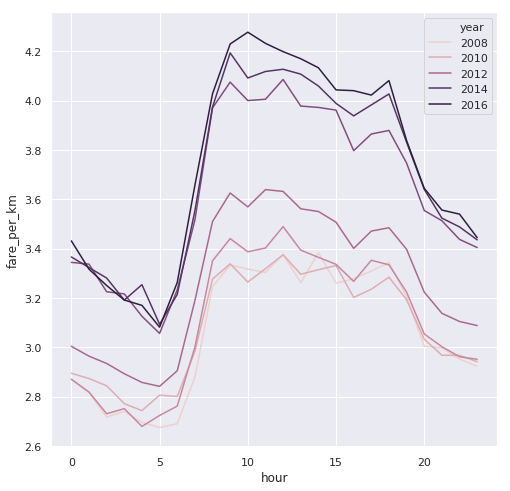

In [42]:
sns.set()
plt.figure(figsize = (8,8))
sns.lineplot(x = 'hour', y = 'fare_per_km', hue = 'year', data = year_day)

In [43]:
# There is huge gap appears after and before 2012, possibly because of price change happend on Sep, 2012

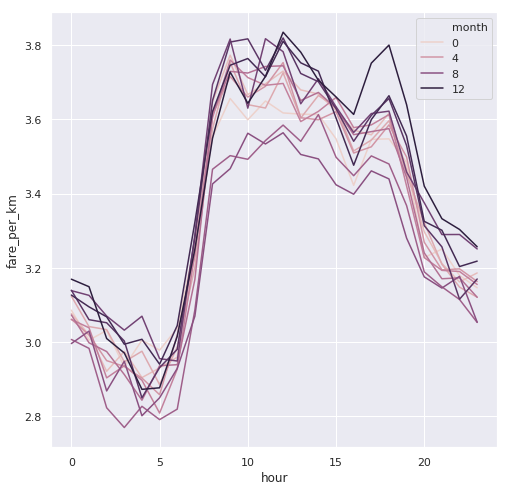

In [44]:
# Month
month_day = train_ll.groupby(['month','hour'])[['fare_amount','distance']].mean()
month_day['fare_per_km'] = month_day['fare_amount']/month_day['distance']
month_day = month_day.reset_index()
sns.set()
plt.figure(figsize = (8,8))
sns.lineplot(x = 'hour', y = 'fare_per_km', hue = 'month', data = month_day)

In [45]:
# Dec is somehow higher

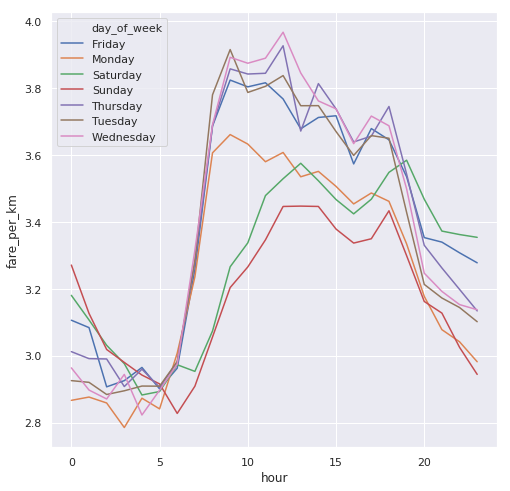

In [46]:
# Day of week
day_day = train_ll.groupby(['day_of_week','hour'])[['fare_amount','distance']].mean()
day_day['fare_per_km'] = day_day['fare_amount']/day_day['distance']
day_day = day_day.reset_index()
sns.set()
plt.figure(figsize = (8,8))
sns.lineplot(x = 'hour', y = 'fare_per_km', hue = 'day_of_week', data = day_day)

In [47]:
# Weekend seems less?

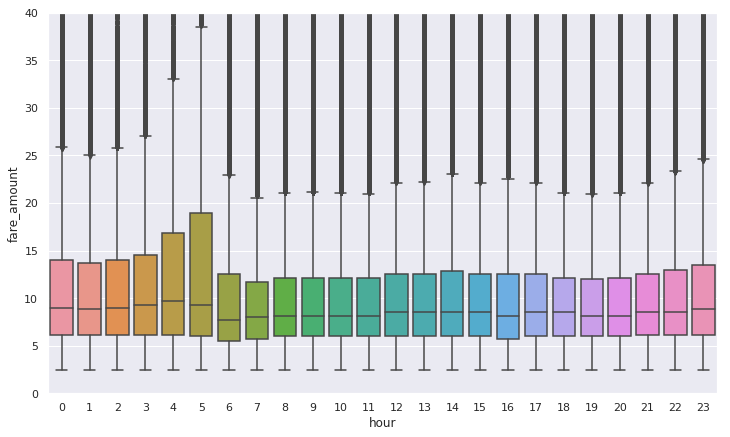

In [48]:
# Overall hour
plt.figure(figsize = (12,7))
plt.ylim(0,40)
sns.boxplot(x = 'hour', y = 'fare_amount', data = train_ll)

In [49]:
# first 5 hours appear somehow higher, this difference could be explained by
# (* Plus 50 cents overnight surcharge 8pm to 6am.)
# From NYC Taxi standard metered fare

In [50]:
train_ll.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,change,year,month,day_of_week,hour
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,1.029601,0.0,2009,6,Monday,17
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,8.443441,0.0,2010,1,Tuesday,16
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389132,0.0,2011,8,Thursday,0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2.795790,0.0,2012,4,Saturday,4
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.998338,0.0,2010,3,Tuesday,7


In [51]:
train_dmy = pd.get_dummies(data=train_ll, columns = ['change','year','month','day_of_week'])

In [52]:
train_ll['lon_diff'] = abs(train_ll['pickup_longitude'] - train_ll['dropoff_longitude'])
train_dmy['lon_diff'] = abs(train_dmy['pickup_longitude'] - train_dmy['dropoff_longitude'])

In [53]:
train_dmy.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,hour,change_0.0,...,month_11,month_12,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,lon_diff
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,1.029601,17,1,...,0,0,0,1,0,0,0,0,0,0.002701
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,8.443441,16,1,...,0,0,0,0,0,0,0,1,0,0.036780
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389132,0,1,...,0,0,0,0,0,0,1,0,0,0.008504
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2.795790,4,1,...,0,0,0,0,1,0,0,0,0,0.004437
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.998338,7,1,...,0,0,0,0,0,0,0,1,0,0.011440


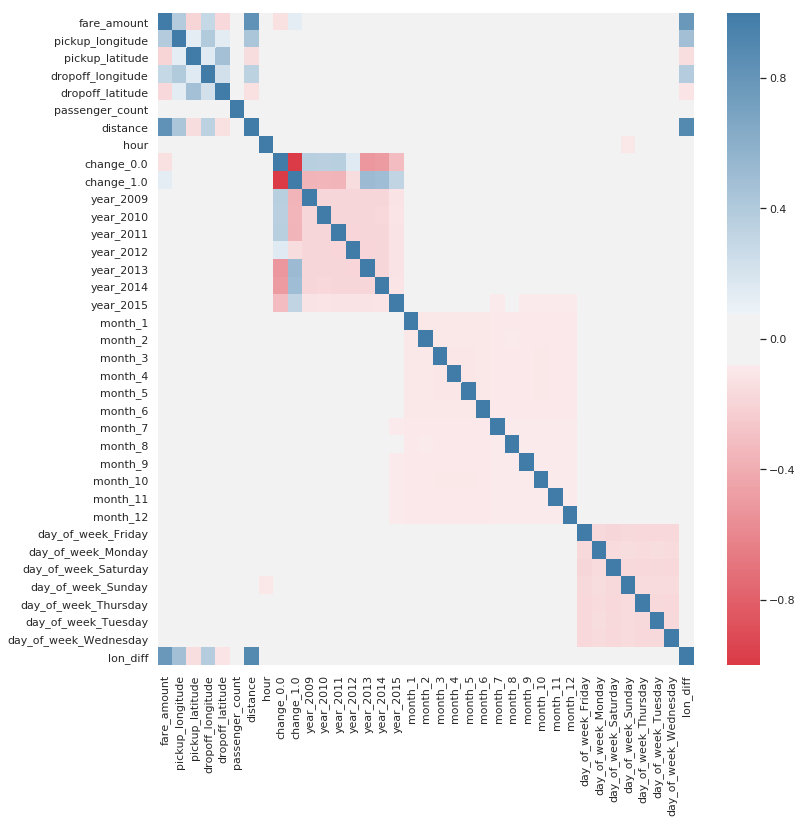

In [54]:
corr_dmy = train_dmy.corr()
plt.figure(figsize = (12,12))
cmap = sns.diverging_palette(10, 240, sep=20, as_cmap=True)
sns.heatmap(corr_dmy, annot = False, cmap = cmap)

In [55]:
# Test 3
train_3_X = train_dmy.drop(columns=['pickup_latitude','pickup_latitude','hour','fare_amount','pickup_datetime'])
train_3_y = train_dmy['fare_amount']

In [56]:
test_linear(train_3_X,train_3_y)

4.93891064926697

In [57]:
# If not including month, year, or day_of_week better？
train_not_month = train_dmy[train_dmy.columns[~train_dmy.columns.str.startswith('month_')]]
train_not_year = train_dmy[train_dmy.columns[~train_dmy.columns.str.startswith('year_')]]
train_not_dayofweek = train_dmy[train_dmy.columns[~train_dmy.columns.str.startswith('day_of_week')]]


In [86]:
# Adding more features According to NYC Taxi standard metered fare
# 1. 
# Whether overnight?

In [87]:
train_ll['overnight'] = 0

In [88]:
train_ll['overnight'][train_ll.hour >= 20] = 1
train_ll['overnight'][train_ll.hour <= 6] = 1

In [89]:
train_ll.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,change,year,month,day_of_week,hour,lon_diff,overnight,rush_hour
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,1.029601,0.0,2009,6,Monday,17,0.002701,0,1
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,8.443441,0.0,2010,1,Tuesday,16,0.036780,0,1
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389132,0.0,2011,8,Thursday,0,0.008504,1,0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2.795790,0.0,2012,4,Saturday,4,0.004437,1,0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.998338,0.0,2010,3,Tuesday,7,0.011440,0,0


In [165]:
# 2.
# Plus $1.00 rush hour surcharge from 4pm to 8pm on weekdays, excluding holidays.

In [91]:
train_ll['rush_hour'] = 0

In [92]:
train_ll['rush_hour'][(train_ll.hour >= 16)&(train_ll.hour < 20)] = 1
train_ll['rush_hour'][(train_ll.day_of_week == 'Sunday')|(train_ll.day_of_week == 'Saturday')] = 0

In [93]:
train_dmy_final = pd.get_dummies(data = train_ll, columns = ['rush_hour','overnight','change','year','month','day_of_week'])

In [96]:
train_ll.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,change,year,month,day_of_week,hour,lon_diff,overnight,rush_hour
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,1.029601,0.0,2009,6,Monday,17,0.002701,0,1
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,8.443441,0.0,2010,1,Tuesday,16,0.036780,0,1
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389132,0.0,2011,8,Thursday,0,0.008504,1,0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2.795790,0.0,2012,4,Saturday,4,0.004437,1,0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.998338,0.0,2010,3,Tuesday,7,0.011440,0,0


In [97]:
trainX = train_ll.drop(columns = ['fare_amount','pickup_datetime','pickup_latitude','dropoff_latitude'])
trainX = pd.get_dummies(data=trainX, columns=['day_of_week'])
trainy = train_ll['fare_amount']

## 4. Set up Model

In [99]:
# --------------------------------xgb--------------------------------

In [ ]:
import xgboost as xgb

In [101]:
data_dmatrix = xgb.DMatrix(data=trainX,label=trainy)

In [102]:
X_train, X_test, y_train, y_test = train_test_split(trainX, trainy, test_size=0.3)

In [126]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear',\
                          colsample_bytree = 0.5,\
                          learning_rate = 0.1,\
                          max_depth = 9,\
                          alpha = 3,\
                          subsample = 1,\
                          gamma = 0)

In [117]:
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

In [118]:
rmse(mean_squared_error(y_test, preds))

3.491780264126522

In [133]:
# Import test set
test = pd.read_csv('test.csv', parse_dates=['pickup_datetime'])

In [134]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
key                  9914 non-null object
pickup_datetime      9914 non-null datetime64[ns]
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 542.2+ KB


In [135]:
# All in one
def test_to_output(df):
    # 1. distance
    distance = []
    for inedx,i in df.iterrows():
        lat1 = i['pickup_latitude']
        lon1 = i['pickup_longitude']
        lat2 = i['dropoff_latitude']
        lon2 = i['dropoff_longitude']
        distance.append(get_km(lat1,lon1,lat2,lon2))
    df['distance'] = distance
    
    # 2. Fare change
    df.loc[df.pickup_datetime < pd.Timestamp('2012/9/30'),'change'] = 0
    df.change.fillna(1, inplace = True)
    
    # 3. Year, month, day_of_week, hour
    df['year'] = df.pickup_datetime.apply(lambda x:x.year)
    df['month'] = df.pickup_datetime.apply(lambda x:x.month)
    df['day_of_week'] = df['pickup_datetime'].dt.day_name()
    df['hour'] = df.pickup_datetime.apply(lambda x:x.hour)
    
    # 4. Difference of longtitude
    df['lon_diff'] = abs(df['pickup_longitude'] - df['dropoff_longitude'])
    
    # 5. Overnight
    df['overnight'] = 0
    df['overnight'][df.hour >= 20] = 1
    df['overnight'][df.hour <= 6] = 1
    
    # 6. Rush hour
    df['rush_hour'] = 0
    df['rush_hour'][(df.hour >= 16)&(df.hour < 20)] = 1
    df['rush_hour'][(df.day_of_week == 'Sunday')|(df.day_of_week == 'Saturday')] = 0
    
    return df
    
    
    

In [136]:
test_ready = test_to_output(test)

In [152]:
test_fit = pd.get_dummies(test_ready.drop(columns = ['key','pickup_datetime','pickup_latitude','dropoff_latitude']),columns = ['day_of_week'])

In [153]:
test_fit.shape[1] == trainX.shape[1]

True

In [154]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear',\
                          colsample_bytree = 0.5,\
                          learning_rate = 0.1,\
                          max_depth = 9,\
                          alpha = 3,\
                          subsample = 1,\
                          gamma = 0)

In [156]:
xg_reg.fit(trainX,trainy)

XGBRegressor(alpha=3, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [157]:
pred_test = xg_reg.predict(test_fit)

In [159]:
submission = pd.DataFrame({'key':test['key'],'fare_amount':pred_test})

In [163]:
submission.to_csv('submission_1.csv',index=False)